In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from czifile import CziFile
from skimage.feature import peak_local_max
from model import MiniUNet

In [2]:
# parameter
CZI_PATH = 'data/images/duodenum_01_3.czi'
MODEL_PATH = 'cell_miniunet.pth'
PATCH_SIZE = 100
STRIDE = 100
THRESHOLD = 0.1
MIN_DISTANCE = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# load model
model = MiniUNet().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

MiniUNet(
  (enc1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (upconv2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    

Image Shape: 2208 x 2752


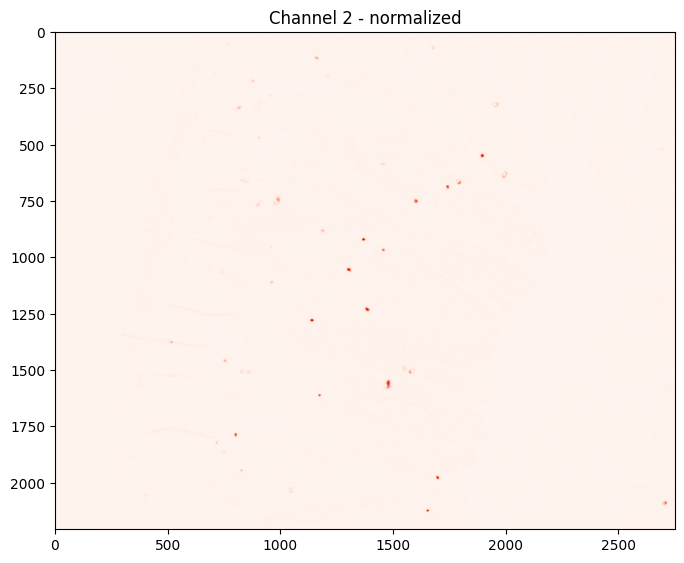

In [8]:
# load image
with CziFile(CZI_PATH) as czi:
    img = czi.asarray()
img = np.squeeze(img)  # [Channels, H, W]
channel_2 = img[1]
channel_2 = (channel_2 - np.min(channel_2)) / (np.max(channel_2) - np.min(channel_2))
image = channel_2.astype(np.float32)

H, W = image.shape
print(f"Image Shape: {H} x {W}")

plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Reds')
plt.title('Channel 2 - normalized')
# plt.axis('off')
plt.show()

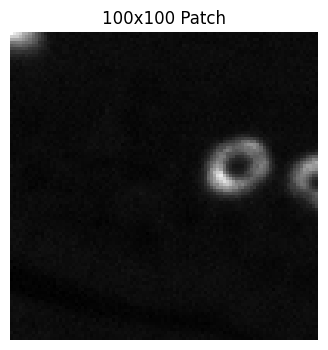

torch.Size([1, 1, 100, 100])


In [10]:
x0, y0 = 756, 1465
patch = image[y0:y0+100, x0:x0+100]

plt.figure(figsize=(4,4))
plt.imshow(patch, cmap='gray')
plt.title('100x100 Patch')
plt.axis('off')
plt.show()

patch_tensor = torch.from_numpy(patch).unsqueeze(0).unsqueeze(0).float()  # [1, 1, 100, 100]
print(patch_tensor.shape)

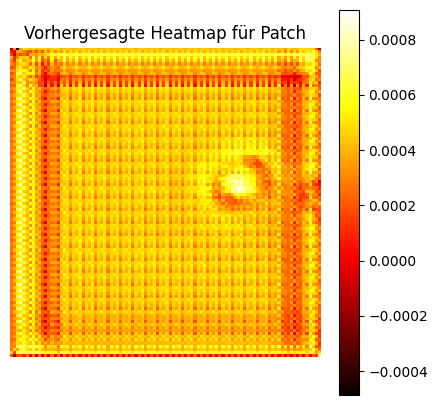

In [11]:
with torch.no_grad():
    pred = model(patch_tensor)

pred_np = pred.squeeze().numpy()

plt.figure(figsize=(5,5))
plt.imshow(pred_np, cmap='hot')
plt.title('Vorhergesagte Heatmap für Patch')
plt.axis('off')
plt.colorbar()
plt.show()

Gefundene Zellen: 31


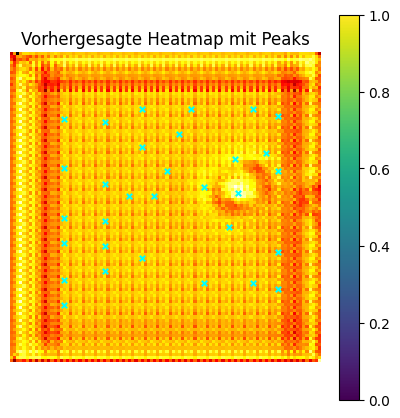

In [13]:
coords = peak_local_max(
    pred_np,
    threshold_abs=0.0003, 
    min_distance=5
)

print(f"Gefundene Zellen: {len(coords)}")

plt.figure(figsize=(5,5))
plt.imshow(pred_np, cmap='hot')
plt.scatter(coords[:, 1], coords[:, 0], c='cyan', s=15, marker='x')
plt.title('Vorhergesagte Heatmap mit Peaks')
plt.axis('off')
plt.colorbar()
plt.show()